In [1]:
from instant_ack import *
from datetime import datetime

%load_ext autoreload
%autoreload 2

2024-10-10 16:10:58.009 | INFO     | instant_ack.config:<module>:11 - PROJ_ROOT path is: /data/instant-ack


# Load data

In [2]:
cols = [
    "quic.frame_type",
    "quic.dcid",
    "quic.scid",
    "ip.src",
    "ip.dst",
    "kind",
    "ts",
    "sni",
    "location",
    "file",
    "measurement_ts",
    "quic.ack.ack_delay",
    "quic.version",
    "tls.quic.parameter.ack_delay_exponent",
    "quic.ack.first_ack_range",
    "quic.long.packet_type",
    "tls.handshake.type",
]

unique_responses = ["measurement_ts", "quic.dcid", "location"]
unique_requests = ["measurement_ts", "quic.scid", "location"]

req = cv.load_data("toplist").filter(pl.col("kind") == "requests")
send_ts = req.group_by(unique_requests).agg(pl.col("ts").min())

In [3]:
tl_responses = (
    cv.load_data("toplist")
    .select(cols)
    .filter(
        pl.col("kind") == "responses",
    )
)
tl_responses = preprocess_qscanner.translate_frame_types(
    tl_responses, "quic.frame_type", "frame_type"
)
tl_responses = preprocess_qscanner.location_to_titlecase(tl_responses)

tl_responses = (
    cv.classify_ack_and_sh_frames(tl_responses, unique_responses)
    .join(
        # Keep only if request was sent
        send_ts,
        how="semi",
        left_on=unique_responses,
        right_on=unique_requests,
    )
    .collect()
)

## Assign CDN

In [4]:
file = config.INTERIM_DATA_DIR / "rib.20240807.0600.pyasn"
asndb = pyasn.pyasn(str(file))

In [5]:
# Look up each address only once and then join
source_addresses_cdn = (
    tl_responses.select("ip.src")
    .unique("ip.src")
    .with_columns(
        pl.col("ip.src")
        .map_elements(lambda x: asndb.lookup(x)[0], return_dtype=pl.UInt64)
        .alias("asn")
    )
    .with_columns(
        pl.col("asn")
        .replace_strict(c.cdn_dict, default="Others", return_dtype=pl.String)
        .alias("CDN")
    )
)
tl_responses = tl_responses.join(
    source_addresses_cdn,
    on="ip.src",
    how="left",
    validate="m:1",
)

### Composition of Others: Section 4.3

In [6]:
tl_responses.filter(pl.col("CDN") == "Others").unique("quic.dcid").group_by(
    ["location", "measurement_ts", "asn"]
).len().sort("len", descending=True)
# The top Ases are hosters: hostinger, ovh, hetzner, automattic (wordpress), bigcommerce (ecommerce)

location,measurement_ts,asn,len
str,datetime[μs],u64,u32
"""hamburg""",2024-08-07 11:23:37.117368,47583,6309
"""hamburg""",2024-08-07 11:23:37.117368,24940,2111
"""hamburg""",2024-08-07 11:23:37.117368,2635,1523
"""hamburg""",2024-08-07 11:23:37.117368,16276,1328
"""hamburg""",2024-08-07 11:23:37.117368,399566,836
…,…,…,…
"""hamburg""",2024-08-07 11:23:37.117368,50911,1
"""hamburg""",2024-08-07 11:23:37.117368,199545,1
"""hamburg""",2024-08-07 11:23:37.117368,137959,1


In [7]:
tl_responses.group_by("CDN").agg(pl.col("sni").n_unique())

CDN,sni
str,u32
"""Cloudflare""",287934
"""Microsoft""",61
"""Others""",33232
"""Amazon""",18588
"""Akamai""",5567
"""Fastly""",3969
"""Meta""",113
"""Google""",6110


### Distribution of first frames per CDN, location and measurement

In [8]:
tl_ack_sh = (
    tl_responses.filter(
        pl.col("ack_first") | pl.col("sh_first"),
        pl.col("first_ack_number"),
    )
    .filter(
        (pl.col("ack_first") & pl.col("sh_first"))
        | (pl.len().over(unique_responses) == 2)
    )
    .with_columns(
        ack_contained=pl.col("ack_first").any().over(unique_responses),
        sh_contained=pl.col("sh_first").any().over(unique_responses),
    )
    .filter(
        # Filter again to remove now smaller than 2 groups
        (pl.col("ack_first") & pl.col("sh_first"))
        | (pl.len().over(unique_responses) == 2)
    )
)

In [9]:
# Sort shifts ACK packets to the front, if they have the same timestamp
tl_first = (
    tl_ack_sh.sort("ts", "frame_type")
    .with_row_index("id")
    .filter(pl.col("id") == pl.col("id").min().over(unique_responses))
)

In [10]:
def get_cdn_stats(tl_first):
    cdn_stats = tl_first.group_by(["CDN", "frame_type"]).len()

    cdn_stats = (
        cdn_stats.sort("CDN")
        .pivot(on="CDN", values="len", index="frame_type")
        .with_columns(
            # Add column for sorting CRYPTO towards the end
            pl.col("frame_type")
            .str.contains("CRYPTO")
            .alias("ack_contained")
        )
        .sort(["ack_contained", "frame_type"])
        .drop("ack_contained")
    )

    totals = (
        cdn_stats.sum()
        .drop("frame_type")
        .transpose(include_header=True, header_name="CDN")
        .rename({"column_0": "Total"})
    )
    totals = totals.with_columns(
        (pl.col("CDN") + "\n(" + pl.col("Total").cast(str) + ")").alias(
            "CDN (# domains)"
        )
    )

    map_cdns = {}
    for cdn, val in totals["CDN", "CDN (# domains)"].iter_rows():
        map_cdns[cdn] = val

    return cdn_stats, map_cdns

## Heatmaps of the first packet content

hamburg, 2024-08-07


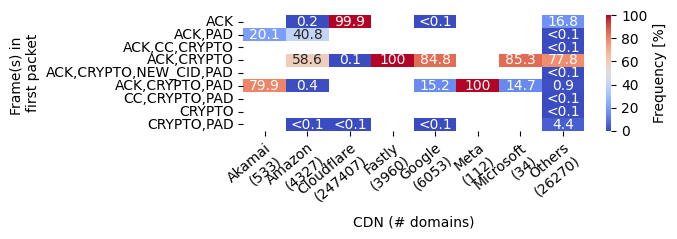

hamburg, 2024-08-08


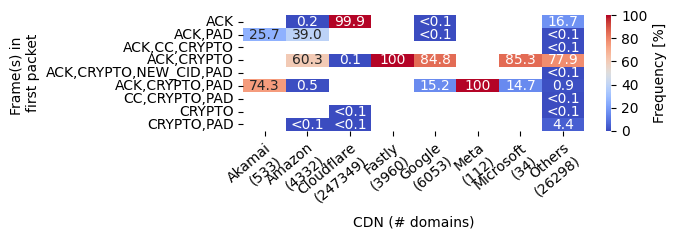

hamburg, 2024-08-09


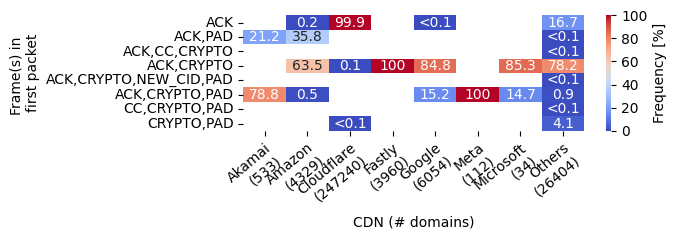

hongkong, 2024-08-07


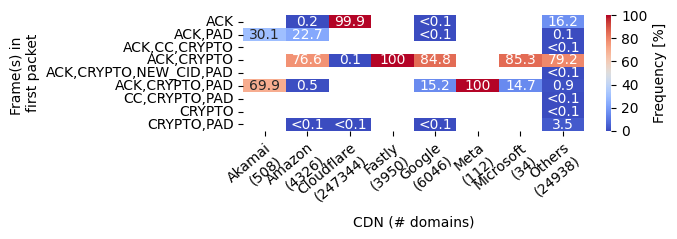

hongkong, 2024-08-08


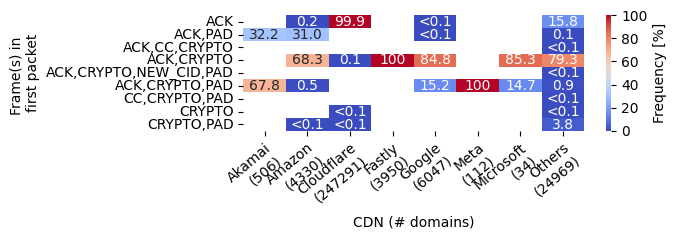

hongkong, 2024-08-09


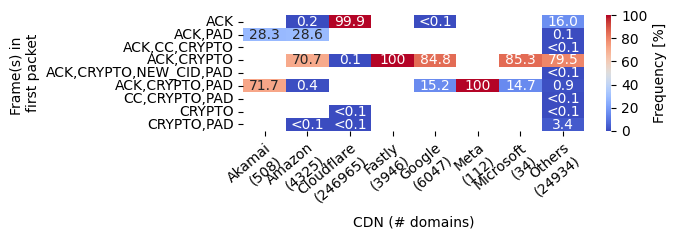

los_angeles, 2024-08-07


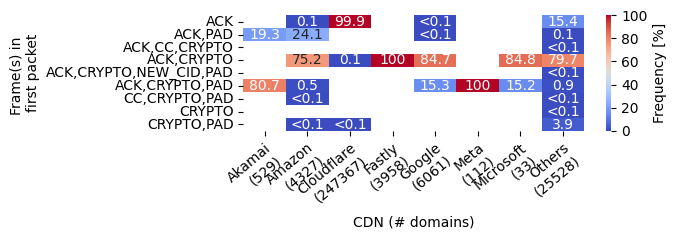

los_angeles, 2024-08-08


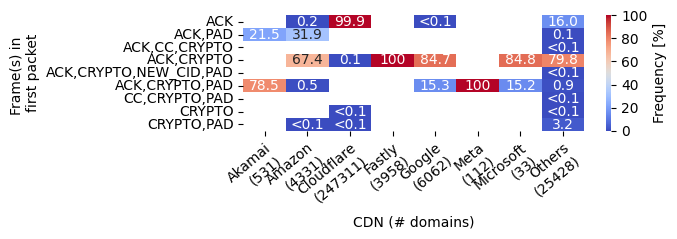

los_angeles, 2024-08-09


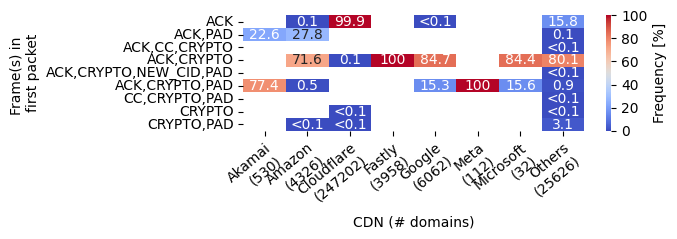

sao_paulo, 2024-08-07


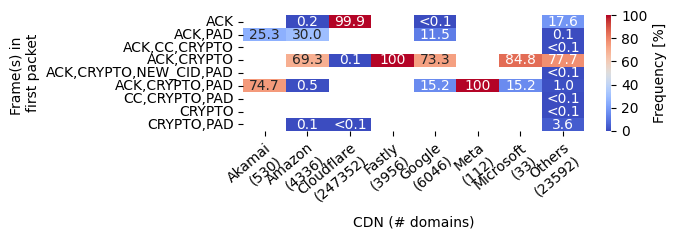

sao_paulo, 2024-08-08


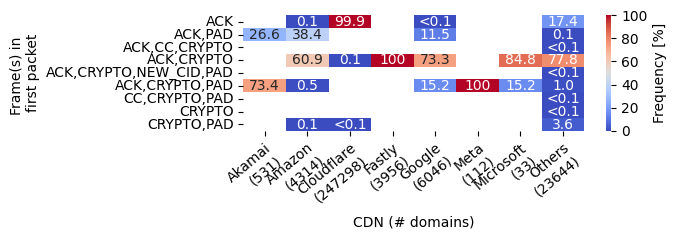

sao_paulo, 2024-08-09


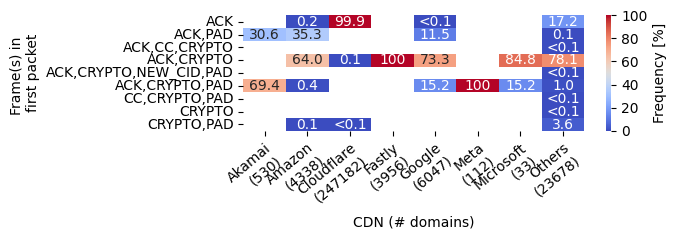

In [11]:
for name, group in tl_first.sort("location").group_by(
    ["location", "measurement_ts"], maintain_order=True
):
    print(f"{name[0]}, {name[1].strftime("%Y-%m-%d")}")
    cdn_stats, map_cdns = get_cdn_stats(group)
    plot.ack_hm(
        cdn_stats.rename(map_cdns),
        figsize=(5.5, 1.5),
        dest=f"toplist/hm-first-packet-{name[0]}-{name[1].strftime("%Y-%m-%d")}",
    )
    plt.show()

### Delay between ACK and SH

In [12]:
ack_sh_delay = (
    tl_ack_sh.with_columns(
        diff_ms=(pl.col("ts").max() - pl.col("ts").min())
        .over(unique_responses)
        .dt.total_microseconds()
        / 1000
    ).sort("frame_type")
    # required to do make sure every domain has weight 1
    .unique(unique_responses, keep="first")
)

### Delay between ACK and SH

In [13]:
data = ack_sh_delay.filter(
    # Show data of a single day
    pl.col("measurement_ts").dt.date()
    == datetime(2024, 8, 7),
).sort("location")

In [14]:
no_instant_ack_cdns = ["Meta", "Microsoft", "Fastly"]

### Delay between ACK and SH, all vantage points: Appendix G, Figure 14

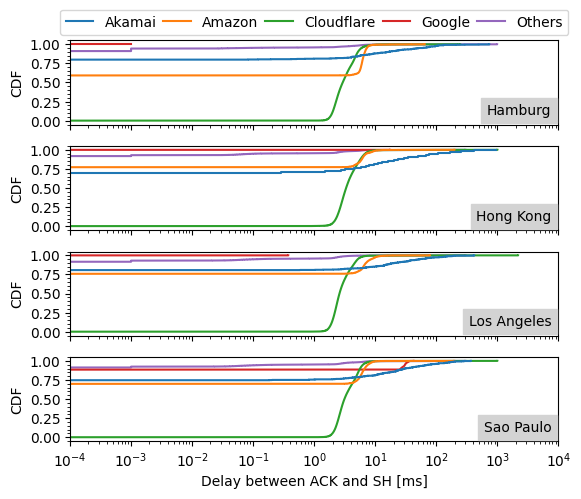

In [15]:
plot.multi(
    data.filter(
        ~pl.col("CDN").is_in(no_instant_ack_cdns),
    ).with_columns(pl.col("geo_location").replace("Hongkong", "Hong Kong")),
    "geo_location",
    figsize=(6, 1.7 * 3),
    x="diff_ms",
    y=None,
    dest="toplist/cdf_toplist_all_locations",
    inner=plot.ecdf,
    anc_loc="lower right",
    anc_text_prefix="",
    anc_text_suffix="",
    legend_ncol=5,
    legend_pos="upper center",
    bbox_to_anchor=(0.5, 1.45),
    sharex=True,
    xlim=(0.0001, 10**4),
    xlabel="Delay between ACK and SH [ms]",
)

### Delay between ACK and SH, vantage point Sao Paulo: Section 4.3, Figure 8

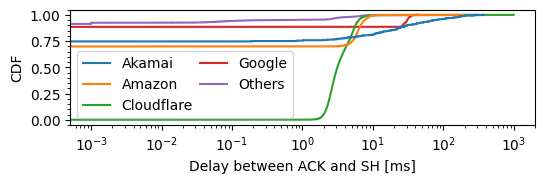

In [16]:
for loc in ["Sao Paulo"]:
    plot.ecdf(
        data.filter(
            ~pl.col("CDN").is_in(no_instant_ack_cdns), pl.col("geo_location") == loc
        ),
        dest=f"toplist/cdf-toplist-{loc.replace(" ", "_")}",
        legend_pos="lower left",
        legend=True,
        legend_ncol=2,
        figsize=(6, 1.5),
    )
    plt.show()

### Delay between ACK and SH, all vantage points and repetitions

Hamburg, 2024-08-07


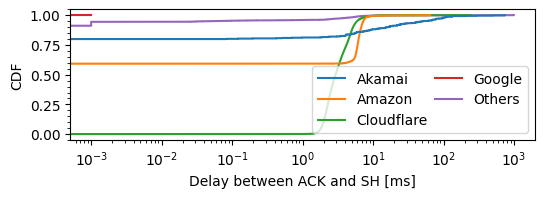

Hamburg, 2024-08-09


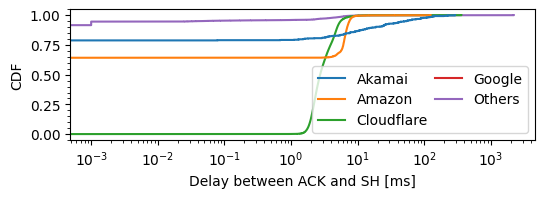

Hamburg, 2024-08-08


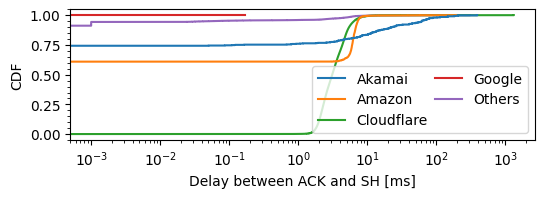

Hongkong, 2024-08-09


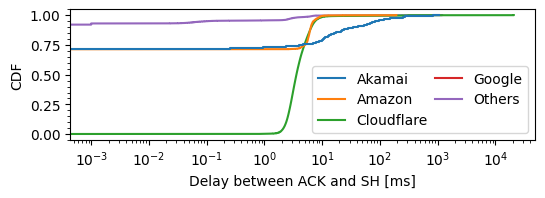

Hongkong, 2024-08-07


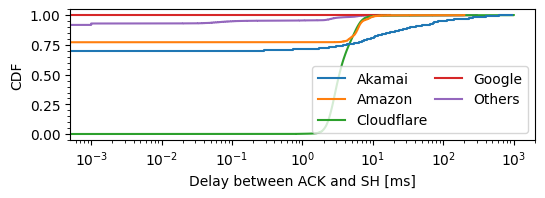

Hongkong, 2024-08-08


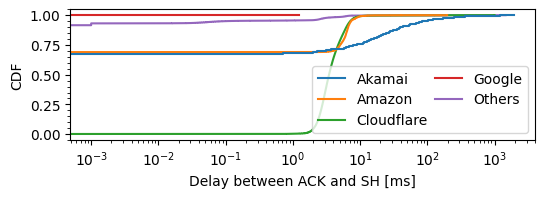

Los Angeles, 2024-08-07


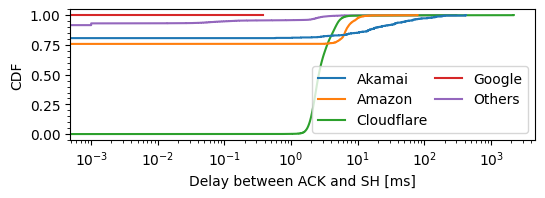

Los Angeles, 2024-08-09


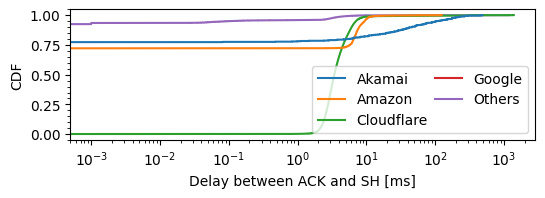

Los Angeles, 2024-08-08


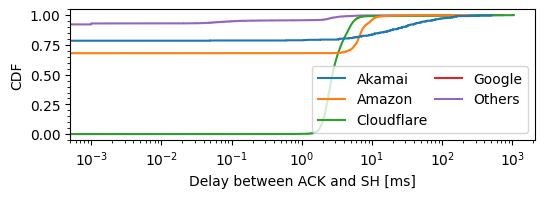

Sao Paulo, 2024-08-07


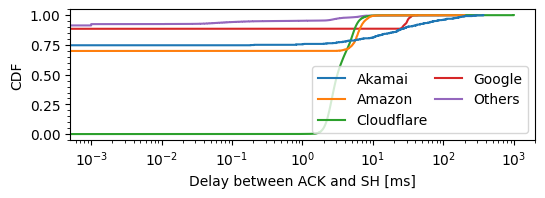

Sao Paulo, 2024-08-09


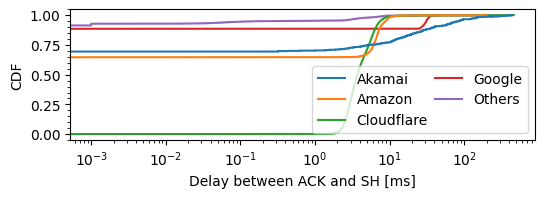

Sao Paulo, 2024-08-08


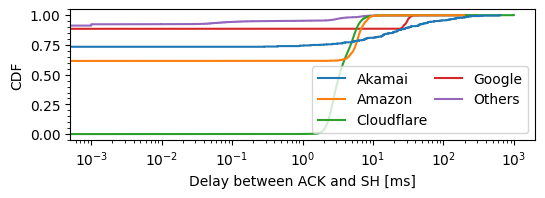

In [17]:
for name, group in ack_sh_delay.sort("location").group_by(
    ["geo_location", "measurement_ts"], maintain_order=True
):
    print(f"{name[0]}, {name[1].strftime("%Y-%m-%d")}")
    plot.ecdf(
        group.filter(
            ~pl.col("CDN").is_in(no_instant_ack_cdns),
        ),
        legend_ncol=2,
        dest=f"toplist/cdf-ack-sh-delay-{name[0].replace(" ", "_")}-{name[1].strftime("%Y-%m-%d")}",
        legend_pos="lower right",
        legend=True,
    )
    plt.show()

### What are the changes between measurements and locations in IACK deployment?

In [18]:
dates = ack_sh_delay.select(
    pl.col("measurement_ts").dt.date().unique().dt.to_string(format="%Y-%m-%d")
)["measurement_ts"].to_list()

In [19]:
diff_dates = (
    ack_sh_delay.with_columns(
        pl.col("measurement_ts").dt.date(),
        iack_share=~(pl.col("ack_first") & pl.col("sh_first")),
    )
    .group_by("geo_location", "measurement_ts", "CDN")
    .agg(pl.sum("iack_share") / pl.len() * 100)
    .pivot(on="measurement_ts", values="iack_share")
    .sort("geo_location", "CDN")
    .with_columns(max_difference=pl.max_horizontal(dates) - pl.min_horizontal(dates))
)
diff_dates

geo_location,CDN,2024-08-09,2024-08-08,2024-08-07,max_difference
str,str,f64,f64,f64,f64
"""Hamburg""","""Akamai""",21.20075,25.703565,20.075047,5.628518
"""Hamburg""","""Amazon""",35.989836,39.242844,40.952161,4.962325
"""Hamburg""","""Cloudflare""",99.944588,99.92359,99.941392,0.020999
"""Hamburg""","""Fastly""",0.0,0.0,0.0,0.0
"""Hamburg""","""Google""",0.033036,0.049562,0.033041,0.016526
…,…,…,…,…,…
"""Sao Paulo""","""Fastly""",0.0,0.0,0.0,0.0
"""Sao Paulo""","""Google""",11.493302,11.511743,11.495203,0.018441
"""Sao Paulo""","""Meta""",0.0,0.0,0.0,0.0


### Section 4.3 and Appendix G

In [20]:
diff_dates.filter(pl.col("max_difference").max() == pl.col("max_difference"))
#  Up to 8.3% difference between same location and different date

geo_location,CDN,2024-08-09,2024-08-08,2024-08-07,max_difference
str,str,f64,f64,f64,f64
"""Sao Paulo""","""Amazon""",35.523283,38.595271,30.258303,8.336969


### Maximum Share of instant ACKs and variations between measurements: Section 4.3, Table 1

In [21]:
diff_dates = (
    ack_sh_delay.with_columns(
        pl.col("measurement_ts").dt.date(),
        iack_share=~(pl.col("ack_first") & pl.col("sh_first")),
    )
    .group_by("geo_location", "measurement_ts", "CDN")
    .agg(pl.sum("iack_share") / pl.len() * 100, domains=pl.col("sni").n_unique())
)
diff = (
    diff_dates.group_by("CDN")
    .agg(
        difference=(pl.col("iack_share").max() - pl.col("iack_share").min()).round(1),
        max_iack_share=pl.col("iack_share").max().round(1),
        domains=pl.col("domains").max().cast(pl.Int64),
    )
    .sort("CDN")
    .transpose(column_names="CDN", include_header=True)
    .sort("column")
)
# Up to 18% difference between different dates and locations
diff

column,Akamai,Amazon,Cloudflare,Fastly,Google,Meta,Microsoft,Others
str,f64,f64,f64,f64,f64,f64,f64,f64
"""difference""",12.9,18.0,0.1,0.0,11.5,0.0,0.0,2.3
"""domains""",533.0,4338.0,247407.0,3960.0,6062.0,112.0,34.0,26404.0
"""max_iack_share""",32.2,41.0,99.9,0.0,11.5,0.0,0.0,21.5


In [22]:
label = "tab:cdn-toplist-observations"
caption = "Domains, share of instant ACK deployment and maximum difference between measurement of different CDN deployments."
print(
    diff.to_pandas()
    .set_index("column")
    .to_latex(label=label, caption=caption, float_format="{:.1f}".format)
)

\begin{table}
\caption{Domains, share of instant ACK deployment and maximum difference between measurement of different CDN deployments.}
\label{tab:cdn-toplist-observations}
\begin{tabular}{lrrrrrrrr}
\toprule
 & Akamai & Amazon & Cloudflare & Fastly & Google & Meta & Microsoft & Others \\
column &  &  &  &  &  &  &  &  \\
\midrule
difference & 12.9 & 18.0 & 0.1 & 0.0 & 11.5 & 0.0 & 0.0 & 2.3 \\
domains & 533.0 & 4338.0 & 247407.0 & 3960.0 & 6062.0 & 112.0 & 34.0 & 26404.0 \\
max_iack_share & 32.2 & 41.0 & 99.9 & 0.0 & 11.5 & 0.0 & 0.0 & 21.5 \\
\bottomrule
\end{tabular}
\end{table}



### Median Interval betweeen ACK and SH: Section 4.3

In [23]:
ack_sh_delay.filter(pl.col("ack_first") & ~pl.col("sh_first")).group_by("CDN").agg(
    pl.col("diff_ms").mean().alias("mean"),
    pl.col("diff_ms").median().alias("median"),
    pl.col("diff_ms").std().alias("std"),
    pl.col("diff_ms").quantile(0.5).alias("50%"),
    pl.col("diff_ms").quantile(0.95).alias("95%"),
    pl.col("diff_ms").quantile(0.99).alias("99%"),
)

CDN,mean,median,std,50%,95%,99%
str,f64,f64,f64,f64,f64,f64
"""Cloudflare""",4.269932,3.18,51.601594,3.18,6.652,9.359
"""Amazon""",6.897781,6.375,6.081951,6.375,9.813,14.222
"""Akamai""",54.222699,20.932,106.247807,20.932,209.659,445.182
"""Google""",29.925694,30.3145,4.762628,30.316,35.808,37.285
"""Others""",2.710771,0.0,23.841941,0.0,6.035,19.495


## Acknowledgment delay

In [24]:
ack_delays = ack_sh_delay.filter(
    pl.col("ack"),
    pl.col("quic.ack.ack_delay").is_not_null(),
).with_columns(
    pl.col("quic.ack.ack_delay").str.split(",").list.get(0).cast(pl.UInt32),
    pl.col("tls.quic.parameter.ack_delay_exponent")
    .forward_fill()
    .over(unique_responses),
)

In [25]:
# Are there multiple ack delays per packet?
ack_sh_delay.filter(pl.col("quic.ack.ack_delay").str.contains(","))

quic.frame_type,quic.dcid,quic.scid,ip.src,ip.dst,kind,ts,sni,location,file,measurement_ts,quic.ack.ack_delay,quic.version,tls.quic.parameter.ack_delay_exponent,quic.ack.first_ack_range,quic.long.packet_type,tls.handshake.type,frame_type,geo_location,cc_in_group,sh,ack,sh_any,ack_any,ack_first,sh_first,first_ack_number,asn,CDN,ack_contained,sh_contained,diff_ms
str,str,str,str,str,str,datetime[μs],str,str,str,datetime[μs],str,str,u32,str,str,str,str,str,bool,bool,bool,bool,bool,bool,bool,bool,u64,str,bool,bool,f64


In [26]:
ack_sh_delay.group_by(unique_responses).len()["len"].value_counts()

len,count
u32,u32
1,3448697


### Compare ACK delay with the actual delay observed on the wire

We now aggregate across measurements

In [27]:
ack_delays = (
    ack_delays.with_columns(
        ack_delay_ms=pl.when(
            pl.col("tls.quic.parameter.ack_delay_exponent").is_not_null()
        )
        .then(
            pl.col("quic.ack.ack_delay")
            * 2 ** pl.col("tls.quic.parameter.ack_delay_exponent")
        )
        .otherwise(
            # This will always be the case for the first ACK of a connection
            # since he server handshake packet with the parameters are not handled yet
            pl.col("quic.ack.ack_delay")
            * 2**3
        )
        / 1000,
    )
    .with_columns(
        diff=pl.col("diff_ms") - pl.col("ack_delay_ms"),
        classification=pl.when(pl.col("sh"))
        .then(pl.lit("ACK,SH"))
        .otherwise(pl.lit("IACK")),
    )
    .sort("CDN")
)

In [28]:
ack_delays_wfc = ack_delays.filter(pl.col("ack_first") & pl.col("sh_first"))
ack_delays_iack = ack_delays.filter(pl.col("ack_first") & ~pl.col("sh_first"))

In [29]:
# Generate fixed color palette, to ease comparison
cdns = sorted(ack_delays.select(pl.col("CDN").unique())["CDN"].to_list())
palette = {}
for i, cdn in enumerate(cdns):
    palette[cdn] = sns.color_palette("tab10")[i]

### WFC Communicated ACK delay vs. measured ACK delay: Appendix D, Figure 10

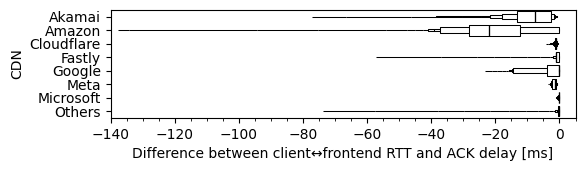

In [30]:
fig, ax = vh.fig_ax()
sns.boxenplot(
    ack_delays_wfc,
    x="diff",
    y="CDN",
    color="white",
    linecolor="black",
    showfliers=False,
)
ax.set(xlim=(-140, 5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.set(xlabel="Difference between client↔frontend RTT and ACK delay [ms]")
vh.save_plot(fig, "toplist/box_toplist_ack_delay_ms_difference_ack_sh")

### Share of Frontend delay - ACK delay < 0

In [31]:
ack_delays.with_columns(lower_zero=pl.col("diff") < 0).group_by(
    "CDN", "classification"
).agg(pl.sum("lower_zero") / pl.len() * 100,).sort("CDN").pivot(
    "CDN", index="classification"
).sort(
    "classification"
)

classification,Akamai,Amazon,Cloudflare,Fastly,Google,Meta,Microsoft,Others
str,f64,f64,f64,f64,f64,f64,f64,f64
"""ACK,SH""",99.767097,87.276088,99.923254,60.541839,34.759055,100.0,41.895262,71.02017
"""IACK""",60.037999,0.763222,0.15182,null,5.829384,null,null,77.937786


### Share of Frontend delay - ACK delay < 1: Appendix G

In [32]:
ack_delays.with_columns(lower_one=pl.col("diff") < 1).group_by(
    "CDN", "classification"
).agg(pl.sum("lower_one") / pl.len() * 100,).sort("CDN").pivot(
    "CDN", index="classification"
).sort(
    "classification"
)

classification,Akamai,Amazon,Cloudflare,Fastly,Google,Meta,Microsoft,Others
str,f64,f64,f64,f64,f64,f64,f64,f64
"""ACK,SH""",99.767097,99.963037,100.0,100.0,100.0,100.0,100.0,99.999583
"""IACK""",60.987967,1.281975,1.461395,null,13.649289,null,null,79.087249


### IACK Communicated ACK delay vs. measured ACK delay: Appendix D, Figure 10

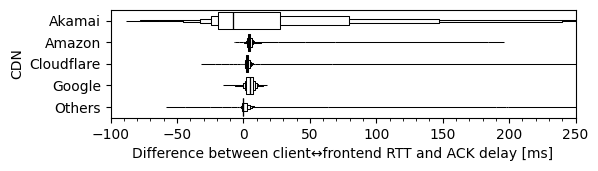

In [33]:
fig, ax = vh.fig_ax()

sns.boxenplot(
    ack_delays_iack,
    x="diff",
    y="CDN",
    color="white",
    linecolor="black",
    showfliers=False,
)
ax.set(xlim=(-100, 250))
ax.set(xlabel="Difference between client↔frontend RTT and ACK delay [ms]")
ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(10))


vh.save_plot(fig, "toplist/box_toplist_ack_delay_ms_difference_iack_large")

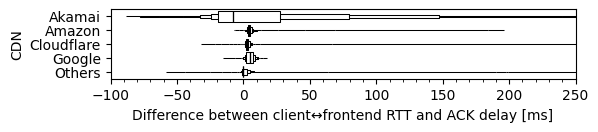

In [34]:
fig, ax = vh.fig_ax(figsize=(6, 0.9))

sns.boxenplot(
    ack_delays_iack,
    x="diff",
    y="CDN",
    color="white",
    linecolor="black",
    showfliers=False,
)
ax.set(xlim=(-100, 250))
ax.set(xlabel="Difference between client↔frontend RTT and ACK delay [ms]")
ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(10))


vh.save_plot(fig, "toplist/box_toplist_ack_delay_ms_difference_iack")

### CDN AS numbers: Appendix G, Table 6

In [35]:
label = "tab:cdn-as"
caption = "CDN inference by AS number."


cdn_as = (
    ack_delays.group_by("CDN")
    .agg(pl.col("asn").unique().cast(pl.String).alias("AS numbers"))
    .with_columns(pl.col("AS numbers").list.join(", "))
    .filter(pl.col("CDN") != "Others")
    .sort("CDN")
)
cdn_as

CDN,AS numbers
str,str
"""Akamai""","""16625, 20940"""
"""Amazon""","""14618, 16509"""
"""Cloudflare""","""13335, 209242"""
"""Fastly""","""54113"""
"""Google""","""15169, 396982"""
"""Meta""","""32934"""
"""Microsoft""","""8075"""


In [36]:
print(cdn_as.to_pandas().set_index("CDN").to_latex(label=label, caption=caption))

\begin{table}
\caption{CDN inference by AS number.}
\label{tab:cdn-as}
\begin{tabular}{ll}
\toprule
 & AS numbers \\
CDN &  \\
\midrule
Akamai & 16625, 20940 \\
Amazon & 14618, 16509 \\
Cloudflare & 13335, 209242 \\
Fastly & 54113 \\
Google & 15169, 396982 \\
Meta & 32934 \\
Microsoft & 8075 \\
\bottomrule
\end{tabular}
\end{table}

